### Deleting best col

In [5]:
import xgboost as xgb

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import sklearn
import copy
from tqdm.notebook import tqdm
from collections import ChainMap


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import time
import dask
# from dask.distributed import Client
# from dask_ml.wrappers import Incremental
import joblib
import os
from pathlib import Path


import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autotime

/home/roman/my_env/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


time: 146 µs (started: 2022-02-27 15:07:37 +03:00)


In [6]:
!ls /data_ny/

time: 111 ms (started: 2022-02-27 15:07:37 +03:00)


In [7]:
fc_hours = 2
fc_colname = f'Dst_+{fc_hours}'

time: 374 µs (started: 2022-02-27 15:07:37 +03:00)


In [8]:
def time_immersion(data, immersion_dict, deep_level, deep_level_forward, fc_levels):
    """
    :param data: pandas DataFrame with source data
    :param immersion_dict: dict with keys - cols_static, cols_deep, cols_deep_forward, cols_fc - each is a list with colnames from source DataFrame
    :param deep_level: how deep is time immersion for cols in immersion_dict['cols_deep']
    :param deep_level_forward: how deep is time immersion for cols in immersion_dict['cols_deep_forward']
    :param fc_levels: list of ints to make forecast cols
    :return: immersioned pandas DataFrame
    """
    a = []
    for colname in immersion_dict['cols_static']:
        a.append(data[colname])
    for deep_cnt in range(deep_level):
        for colname in immersion_dict['cols_deep']:
            a.append(data[colname].shift(deep_cnt).rename(f'{colname}_-{deep_cnt}'))
#     for deep_cnt in range(deep_level_forward):
#         for colname in immersion_dict['cols_deep_forward']:
#             a.append(data[colname].shift(-deep_cnt).rename(f'{colname}_+{deep_cnt}'))
    for deep_cnt in fc_levels:
        for colname in immersion_dict['cols_fc']:
            a.append(data[colname].shift(-deep_cnt).rename(f'{colname}_+{deep_cnt}'))
    return pd.concat(a, axis=1)


def trn_tst_scal(data, X_list, y_list, trn_cond, in_scaler, out_scaler):
    """

    :param data: source pandas DataFrame
    :param X_list: list of names of X columns
    :param y_list: list of names of y columns
    :param trn_cond: boolean pandas Series or list of boolean values of the same shape as data.shape[0]
    :param in_scaler: scaler object for inputs
    :param out_scaler: scaler object for outputs
    :return:
        X_trn_std - dataframe of normalized x values of train set
        y_trn_std - dataframe of normalized y values of train set
        X_tst_std - dataframe of normalized x values of test set
        y_tst_std - dataframe of normalized y values of test set
        x_scaler - in_scaler trained on x data of train set
        y_scaler - out_scaler trained on y data of train set
    """
    X = data[X_list]
    y = data[y_list]
    X_trn = X[trn_cond]
    X_tst = X[~trn_cond]
    y_trn = y[trn_cond]
    y_tst = y[~trn_cond]

    in_scaler.fit(X_trn)

    X_trn_std = pd.DataFrame(in_scaler.transform(X_trn), index=X_trn.index)
    X_tst_std = pd.DataFrame(in_scaler.transform(X_tst), index=X_tst.index)

    X_trn_std.columns = X_trn.columns
    X_tst_std.columns = X_tst.columns

    out_scaler.fit(y_trn)

    y_trn_std = pd.DataFrame(out_scaler.transform(y_trn), index=y_trn.index)
    y_tst_std = pd.DataFrame(out_scaler.transform(y_tst), index=y_tst.index)

    y_trn_std.columns = y_trn.columns
    y_tst_std.columns = y_tst.columns

    return X_trn_std, y_trn_std, X_tst_std, y_tst_std, in_scaler, out_scaler


time: 1.96 ms (started: 2022-02-27 15:07:38 +03:00)


In [9]:
import unicodedata
import string
valid_filename_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
char_limit = 255
def clean_filename(filename, whitelist=valid_filename_chars, replace=' '):
    # replace spaces
    for r in replace:
        filename = filename.replace(r,'_')
    
    # keep only valid ascii chars
    cleaned_filename = unicodedata.normalize('NFKD', filename).encode('ASCII', 'ignore').decode()
    
    # keep only whitelisted chars
    cleaned_filename = ''.join(c for c in cleaned_filename if c in whitelist)
    if len(cleaned_filename)>char_limit:
        print("Warning, filename truncated because it was over {}. Filenames may no longer be unique".format(char_limit))
    return cleaned_filename[:char_limit]    

time: 2.09 ms (started: 2022-02-27 15:07:39 +03:00)


In [10]:
data_new = pd.read_pickle('/home/roman/Projects/Cosmos/GPU_features_selection_exps/All_browse_data_без_погружения_19971021_20211231_интерполяция12.pickle')

time: 49.6 ms (started: 2022-02-27 15:09:12 +03:00)


In [11]:
base_immersion_dict = {
    
'cols_info' : ['year', 'month', 'day', 'hour from', 'hour to'],
'cols_static' : ['doySin', 'hourSin', 'doyCos', 'hourCos'],
'cols_deep' : [
    'Dst',
    'B_gsm_y',
    'B_gsm_z', 
    'B_magn', 
    'SW_spd',
    'H_den_SWP'],
'cols_deep_forward' : [
],
'cols_fc' : ['Dst']
}

time: 433 µs (started: 2022-02-27 15:09:12 +03:00)


In [12]:
deep_level = 24
horizons = [1,2,3,4,5,6]
train_last_year = 2016

time_immersion(data_new, base_immersion_dict, deep_level, 0, horizons).shape

(212328, 154)

time: 332 ms (started: 2022-02-27 15:09:13 +03:00)


In [13]:
data_transformed = time_immersion(data_new, base_immersion_dict, deep_level, 0, horizons).dropna()
data_transformed.shape

(210454, 154)

time: 397 ms (started: 2022-02-27 15:09:14 +03:00)


In [14]:
# data_transformed = data_transformed.sample(100).copy()

time: 213 µs (started: 2022-02-27 15:09:17 +03:00)


In [15]:
trn_cond = data_transformed.index.year<=train_last_year

X = data_transformed[data_transformed.columns[:-6]]
y = data_transformed[data_transformed.columns[-6:]]

in_scaler = MinMaxScaler(feature_range=(-1,1))
out_scaler = MinMaxScaler(feature_range=(-1,1))

time: 77.2 ms (started: 2022-02-27 15:09:17 +03:00)


In [16]:
X_trn_std, y_trn_std, X_tst_std, y_tst_std, in_, out_= trn_tst_scal(data_transformed, X.columns, [fc_colname], trn_cond, in_scaler, out_scaler)

time: 391 ms (started: 2022-02-27 15:09:19 +03:00)


In [18]:
# @dask.delayed
def fitter(est, x_tr, y_tr, x_ts, y_ts, col, iter_num):
    x_tr_new = x_tr.drop(col, axis=1)
    x_ts_new = x_ts.drop(col, axis=1)
    
    rmse = []
    for i in range(5):
        model_filename = clean_filename(f'iter_{iter_num}_{col}_dropped_model_{i}.joblib')    
        model_filepath = os.path.join(experiment_dir, model_filename)
        
        rmse_filename = clean_filename(f'iter_{iter_num}_{col}_dropped_model_{i}_rmse_tst.txt')
        rmse_filepath = os.path.join(experiment_dir, rmse_filename)
#         print(rmse_filepath)
        if os.path.isfile(rmse_filepath):
            with open(rmse_filepath, 'r') as f:
                rmse_tst_curr = float(f.read())
        else:
            if os.path.isfile(model_filepath):
                model = joblib.load(model_filepath)
            else:
                model = est
                model.random_state = i
                a = time.perf_counter()
                model.fit(x_tr_new, y_tr)
#                 print(time.perf_counter()-a, 'seconds fitted')
                joblib.dump(model, model_filepath)
            rmse_tst_curr = np.sqrt(
                mean_squared_error(
                    out_scaler.inverse_transform(y_ts), \
                    out_scaler.inverse_transform(model.predict(x_ts_new).reshape(-1,1))
                )
            )
            with open(rmse_filepath, 'w') as f:
                f.write(str(rmse_tst_curr))
        rmse.append(rmse_tst_curr)
        
    return {col: rmse}

time: 3.23 ms (started: 2022-02-27 15:09:22 +03:00)


In [19]:
def feature_estimator(estimator, x_trn, y_trn, x_tst, y_tst, iter_num):
    output = []
    rmse = []
  
    for column in cols_for_check:
        output.append(fitter(sklearn.base.clone(estimator), x_trn, y_trn, x_tst, y_tst, column, iter_num))        
    result = dask.delayed(list)(output).compute()
    
    return result

time: 713 µs (started: 2022-02-27 15:09:23 +03:00)


In [17]:
# !ls /home/roman/Projects/Cosmos/feature_selection_trn2016_classic_linreg_del_2h/*

time: 732 µs (started: 2022-02-27 01:55:30 +03:00)


In [20]:
experiment_dir = f'/home/roman/Projects/Cosmos/GPU_features_selection_exps/feature_selection_trn2016_GB_del_{fc_hours}h/'
# results_filename = 'results.csv'
# results_filepath = os.path.join(experiment_dir, results_filename)

# создаем папку эксперимента. в нее все будет сохраняться
Path(experiment_dir).mkdir(parents=True, exist_ok=True)

time: 1.23 ms (started: 2022-02-27 15:09:24 +03:00)


In [20]:
lst = list(X_trn_std.columns.values[4:])
cols_errors = {}
colonki = pd.DataFrame()
colonki_2 = pd.DataFrame(index=lst, columns=range(144))
res = pd.DataFrame()
commit_res = {}

regressor = xgb.XGBRegressor('reg:squarederror',
                              n_estimators=100,
                              max_depth=5,
                              learning_rate=0.05,
                              tree_method='gpu_hist')

for n in tqdm(range(144), desc='main_iter'):
    full_res = []
    for i in tqdm(range(0, 144, 10), desc='sub_iter', leave=False):
        if len(lst) >= i:
            cols_for_check = lst[i:i+10]
            full_res.extend(feature_estimator(regressor, X_trn_std, y_trn_std, X_tst_std, y_tst_std, n))
            
    colonki_2[n] = pd.Series(dict(ChainMap(*full_res)))
    column_for_drop = colonki_2.applymap(np.mean).idxmin()[n]
    colonki.append(lst)
    
    X_trn_std.drop(column_for_drop, axis=1, inplace=True)
    X_tst_std.drop(column_for_drop, axis=1, inplace=True)
    
    lst.remove(column_for_drop)

/home/roman/my_env/lib/python3.8/site-packages/xgboost/core.py:430: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


main_iter:   0%|          | 0/144 [00:00<?, ?it/s]

sub_iter:   0%|          | 0/15 [00:00<?, ?it/s]

/home/roman/my_env/lib/python3.8/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


KeyboardInterrupt: 

time: 2.54 s (started: 2022-02-10 16:00:38 +03:00)


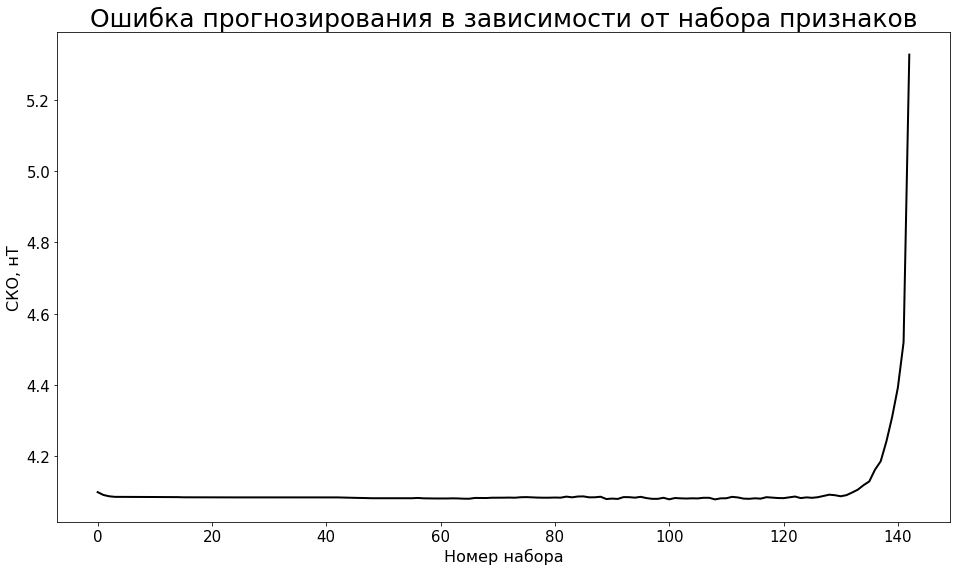

time: 442 ms (started: 2022-02-08 21:37:22 +03:00)


In [22]:
ax = colonki_2.applymap(np.mean).min()[:-1].plot(figsize=(16,9))
plt.style.use('ggplot')
ax.set_title("Ошибка прогнозирования в зависимости от набора признаков", {'fontsize':25})
ax.set_ylabel("СКО, нТ", {'fontsize':16})
ax.set_xlabel("Номер набора", {'fontsize':16})
# ax.legend(loc=4, prop={'size': 15})
plt.setp(ax.lines, linewidth=2, color='k')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.get_figure().savefig(f'Errs_of_sets_{fc_hours}h.png')
plt.show()

<AxesSubplot:>

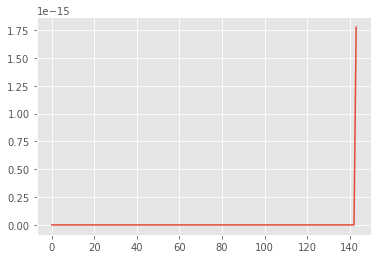

time: 519 ms (started: 2022-02-03 21:16:40 +03:00)


In [22]:
colonki_2.applymap(np.std).max().plot()

In [21]:
colonki_filename = os.path.join(experiment_dir, 'colonki_2.pickle')
if os.path.exists(colonki_filename):
    colonki_2 = pd.read_pickle(colonki_filename)
else:
    colonki_2.to_pickle(colonki_filename)

time: 72.9 ms (started: 2022-02-27 15:09:28 +03:00)


Отбор линрегом завершен, используем далее colonki_2
==

In [22]:
colonki_2.applymap(np.mean).min().idxmin()

108

time: 168 ms (started: 2022-02-27 15:09:33 +03:00)


In [23]:
iter_num = colonki_2.applymap(np.mean).min().idxmin()
col = colonki_2.applymap(np.mean).min(axis=1).idxmin()
i = 0

best_set = colonki_2.applymap(np.mean)[[iter_num]].dropna().index.tolist()
best_set.extend(['doySin', 'hourSin', 'doyCos', 'hourCos'])
best_set.remove(col)
best_set = best_set[-4:] + best_set[:-4]
len(best_set), best_set

(39,
 ['doySin',
  'hourSin',
  'doyCos',
  'hourCos',
  'Dst_-0',
  'B_gsm_z_-0',
  'B_magn_-0',
  'SW_spd_-0',
  'H_den_SWP_-0',
  'Dst_-1',
  'B_gsm_z_-1',
  'SW_spd_-1',
  'H_den_SWP_-1',
  'B_gsm_z_-2',
  'SW_spd_-2',
  'H_den_SWP_-2',
  'Dst_-3',
  'B_gsm_z_-3',
  'B_magn_-3',
  'B_magn_-4',
  'SW_spd_-4',
  'Dst_-5',
  'B_gsm_y_-6',
  'Dst_-7',
  'B_gsm_y_-8',
  'Dst_-9',
  'Dst_-10',
  'Dst_-11',
  'B_magn_-11',
  'B_magn_-12',
  'B_magn_-15',
  'SW_spd_-16',
  'Dst_-19',
  'Dst_-20',
  'Dst_-21',
  'SW_spd_-21',
  'Dst_-22',
  'B_gsm_y_-22',
  'Dst_-23'])

time: 458 ms (started: 2022-02-27 15:09:35 +03:00)


Линрег на лучшем для нее отборе и на полном
==

In [24]:
linreg_full = LinearRegression()
linreg_best = LinearRegression()

X_trn_std, y_trn_std, X_tst_std, y_tst_std, in_, out_= trn_tst_scal(data_transformed, X.columns, [fc_colname], trn_cond, in_scaler, out_scaler)

linreg_full.fit(X_trn_std, y_trn_std)
linreg_best.fit(X_trn_std[best_set], y_trn_std)

LinearRegression()

time: 3.54 s (started: 2022-02-27 15:09:36 +03:00)


In [27]:
xgb_full = xgb.XGBRegressor('reg:squarederror',
                              n_estimators=1500,
                              max_depth=4,
                              learning_rate=0.05,
                              tree_method='gpu_hist')
xgb_best = xgb.XGBRegressor('reg:squarederror',
                              n_estimators=1500,
                              max_depth=4,
                              learning_rate=0.05,
                              tree_method='gpu_hist')

X_trn_std, y_trn_std, X_tst_std, y_tst_std, in_, out_= trn_tst_scal(data_transformed, X.columns, [fc_colname], trn_cond, in_scaler, out_scaler)

xgb_full.fit(X_trn_std, y_trn_std)
xgb_best.fit(X_trn_std[best_set], y_trn_std)

print('Train')
print(xgb_full.score(X_trn_std, y_trn_std))
print(xgb_full.score(X_tst_std, y_tst_std))
print('\n')

print('Test')
print(xgb_best.score(X_trn_std[best_set], y_trn_std))
print(xgb_best.score(X_tst_std[best_set], y_tst_std))

/home/roman/my_env/lib/python3.8/site-packages/xgboost/core.py:430: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
/home/roman/my_env/lib/python3.8/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/roman/my_env/lib/python3.8/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Train
0.9630391561409243
0.9075577602185856


Test
0.9601552620847822
0.9058871059611744
time: 1min 33s (started: 2022-02-27 15:10:58 +03:00)


Сортируем колонки для доп отбора фичей для mlp
==

In [28]:
len(best_set)

39

time: 2.08 ms (started: 2022-02-27 15:12:32 +03:00)


In [29]:
all_features_sorted_importance = colonki_2.notnull().sum(axis=1).sort_values(ascending=False).index.to_list()
best_set_sorted = [x for x in all_features_sorted_importance if x in best_set]

time: 8.29 ms (started: 2022-02-27 15:12:32 +03:00)


In [30]:
best_set_sorted, best_set

(['Dst_-0',
  'B_gsm_z_-0',
  'SW_spd_-0',
  'B_gsm_z_-3',
  'B_gsm_z_-1',
  'Dst_-21',
  'H_den_SWP_-0',
  'H_den_SWP_-2',
  'Dst_-7',
  'B_magn_-4',
  'B_gsm_z_-2',
  'H_den_SWP_-1',
  'Dst_-5',
  'Dst_-3',
  'SW_spd_-1',
  'B_magn_-0',
  'Dst_-10',
  'B_gsm_y_-8',
  'SW_spd_-2',
  'Dst_-19',
  'Dst_-20',
  'Dst_-1',
  'B_magn_-15',
  'B_gsm_y_-6',
  'Dst_-22',
  'SW_spd_-4',
  'B_magn_-11',
  'B_magn_-3',
  'SW_spd_-16',
  'Dst_-23',
  'B_gsm_y_-22',
  'Dst_-11',
  'B_magn_-12',
  'Dst_-9',
  'SW_spd_-21'],
 ['doySin',
  'hourSin',
  'doyCos',
  'hourCos',
  'Dst_-0',
  'B_gsm_z_-0',
  'B_magn_-0',
  'SW_spd_-0',
  'H_den_SWP_-0',
  'Dst_-1',
  'B_gsm_z_-1',
  'SW_spd_-1',
  'H_den_SWP_-1',
  'B_gsm_z_-2',
  'SW_spd_-2',
  'H_den_SWP_-2',
  'Dst_-3',
  'B_gsm_z_-3',
  'B_magn_-3',
  'B_magn_-4',
  'SW_spd_-4',
  'Dst_-5',
  'B_gsm_y_-6',
  'Dst_-7',
  'B_gsm_y_-8',
  'Dst_-9',
  'Dst_-10',
  'Dst_-11',
  'B_magn_-11',
  'B_magn_-12',
  'B_magn_-15',
  'SW_spd_-16',
  'Dst_-19',
  'D

time: 3.9 ms (started: 2022-02-27 15:12:32 +03:00)


Отбор от 3 фичей, не считая синусов до 22 либо до длины лучшего набора (обсуждаемо)
===
В качестве резов rmse и r2 для трейна и теста
===

In [31]:
emsembles_path = os.path.join(experiment_dir, 'ensembles')
Path(emsembles_path).mkdir(parents=True, exist_ok=True)

time: 693 µs (started: 2022-02-27 15:12:32 +03:00)


In [32]:
emsembles_path

'/home/roman/Projects/Cosmos/GPU_features_selection_exps/feature_selection_trn2016_GB_del_2h/ensembles'

time: 2.48 ms (started: 2022-02-27 15:12:32 +03:00)


In [ ]:
trn_rmse = []
tst_rmse = []

trn_r2 = []
tst_r2 = []
X_trn_std, y_trn_std, X_tst_std, y_tst_std, in_, out_= trn_tst_scal(data_transformed, X.columns, [fc_colname], trn_cond, in_scaler, out_scaler)
for n in range(3, 32):
    features = ['doySin', 'hourSin', 'doyCos', 'hourCos'] + best_set_sorted[:n]
    if os.path.isfile(f'{emsembles_path}/mlp_model_{n}'):
        encemb = joblib.load(f'{emsembles_path}/mlp_model_{n}')
    else:
        encemb = VotingRegressor([("0", MLPRegressor(hidden_layer_sizes=(32,),
                                              solver='sgd',
                                              learning_rate_init=0.001,
                                              alpha=0.01,
                                              validation_fraction=0.2,
                                              max_iter=3000,
                                              n_iter_no_change=500,
                    #                               verbose=True, 
                                              early_stopping=True,
                                              activation='tanh')),
                                 ("1", MLPRegressor(hidden_layer_sizes=(32,),
                                              solver='sgd',
                                              learning_rate_init=0.001,
                                              alpha=0.01,
                                              validation_fraction=0.2,
                                              max_iter=3000,
                                              n_iter_no_change=500,
                    #                               verbose=True, 
                                              early_stopping=True,
                                              activation='tanh')),
                                 ("2", MLPRegressor(hidden_layer_sizes=(32,),
                                              solver='sgd',
                                              learning_rate_init=0.001,
                                              alpha=0.01,
                                              validation_fraction=0.2,
                                              max_iter=3000,
                                              n_iter_no_change=500,
                    #                               verbose=True, 
                                              early_stopping=True,
                                              activation='tanh')),
                                 ("3", MLPRegressor(hidden_layer_sizes=(32,),
                                              solver='sgd',
                                              learning_rate_init=0.001,
                                              alpha=0.01,
                                              validation_fraction=0.2,
                                              max_iter=3000,
                                              n_iter_no_change=500,
                    #                               verbose=True, 
                                              early_stopping=True,
                                              activation='tanh')),
                                 ("4", MLPRegressor(hidden_layer_sizes=(32,),
                                              solver='sgd',
                                              learning_rate_init=0.001,
                                              alpha=0.01,
                                              validation_fraction=0.2,
                                              max_iter=3000,
                                              n_iter_no_change=500,
                    #                               verbose=True, 
                                              early_stopping=True,
                                              activation='tanh'))])
        encemb.fit(X_trn_std[features], y_trn_std)
        joblib.dump(encemb, f'{emsembles_path}/mlp_model_{n}')

    
    comm_trn_rmse = []
    comm_tst_rmse = []
    comm_trn_r2 = []
    comm_tst_r2 = []
    for i in range(5):
        model = encemb.named_estimators_[str(i)]

        best_trn_rmse = np.sqrt(mean_squared_error(out_scaler.inverse_transform(y_trn_std), \
        out_scaler.inverse_transform(model.predict(X_trn_std[features]).reshape(-1,1))))
        comm_trn_rmse.append(best_trn_rmse)
        
        best_tst_rmse = np.sqrt(mean_squared_error(out_scaler.inverse_transform(y_tst_std), \
        out_scaler.inverse_transform(model.predict(X_tst_std[features]).reshape(-1,1))))
        comm_tst_rmse.append(best_trn_rmse)

        best_trn_r2 = r2_score(out_scaler.inverse_transform(y_trn_std), \
        out_scaler.inverse_transform(model.predict(X_trn_std[features]).reshape(-1,1)))
        comm_trn_r2.append(best_trn_r2)
        
        best_tst_r2 = r2_score(out_scaler.inverse_transform(y_tst_std), \
        out_scaler.inverse_transform(model.predict(X_tst_std[features]).reshape(-1,1)))
        comm_tst_r2.append(best_trn_r2)
        
    
    
    trn_rmse.append(comm_trn_rmse)
    tst_rmse.append(comm_tst_rmse)
    trn_r2.append(comm_trn_r2)
    tst_r2.append(comm_tst_r2)
    print(n, ':', comm_trn_rmse, comm_tst_rmse)
    print(n, ':', comm_trn_r2, comm_tst_r2, '\n')

In [ ]:
len(tst_r2)

In [ ]:
comm_res = pd.DataFrame()
comm_res['mean'] = pd.DataFrame(tst_rmse).T.mean()
comm_res['std'] = pd.DataFrame(tst_rmse).T.std()

x = list(range(3, len(tst_r2) + 3))

import matplotlib.pyplot as plt

plt.figure(figsize=(16,9))
plt.plot(x, comm_res['mean'], color='b')
plt.plot(x, comm_res['mean'], 'o', color='b')

# plt.plot(comm_res['y-err'])
# plt.plot(comm_res['y+err'])


plt.fill_between(x,
                 comm_res['mean'] - comm_res['std'],
                 comm_res['mean'] + comm_res['std'], color='b', alpha=0.2)

plt.ylabel('RMSE')
plt.xlabel('Number of features')
plt.savefig(f'committee_mlp_rmse_std_{fc_hours}h.png')
plt.show()

In [32]:
mlp_otbor_rmse = pd.DataFrame({'trn_rmse':trn_rmse,
            'tst_rmse':tst_rmse})
mlp_otbor_rmse.index = range(3, 32)
mlp_otbor_rmse.to_csv(f'mlp_otbor_rmse_{fc_hours}h.csv')

time: 4.66 ms (started: 2022-02-27 01:59:27 +03:00)


In [33]:
mlp_otbor_rmse.applymap(np.mean)

,trn_rmse,tst_rmse
3,6.053497,6.053497
4,5.881912,5.881912
5,5.881480,5.881480
6,5.852014,5.852014
7,5.810650,5.810650
8,5.658401,5.658401
9,5.684715,5.684715
10,5.553776,5.553776
11,5.531536,5.531536
12,5.471193,5.471193


time: 9.25 ms (started: 2022-02-27 01:59:27 +03:00)


In [34]:
from IPython.display import FileLink
FileLink(f'mlp_otbor_rmse_{fc_hours}h.csv')

/home/roman/Projects/Cosmos/GPU_features_selection_exps/mlp_otbor_rmse_2h.csv

time: 2.36 ms (started: 2022-02-27 01:59:27 +03:00)


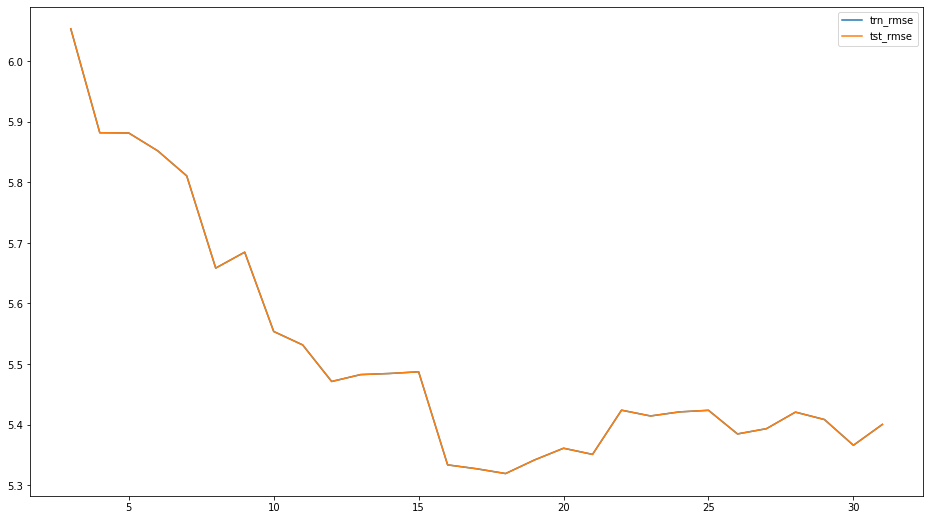

time: 180 ms (started: 2022-02-27 01:59:27 +03:00)


In [35]:
ax = mlp_otbor_rmse.applymap(np.mean).plot(figsize=(16,9))
# ax.get_figure().savefig('mlp_otbor_rmse_1h_committee.png')

In [36]:
mlp_otbor_r2 = pd.DataFrame({'trn_r2':trn_r2,'tst_r2':tst_r2})
mlp_otbor_r2.index = range(3, 32)
mlp_otbor_r2.to_csv(f'mlp_otbor_r2_{fc_hours}h.csv')
FileLink(f'mlp_otbor_r2_{fc_hours}h.csv')

/home/roman/Projects/Cosmos/GPU_features_selection_exps/mlp_otbor_r2_2h.csv

time: 4.99 ms (started: 2022-02-27 01:59:27 +03:00)


In [37]:
mlp_otbor_r2.applymap(np.mean)

,trn_r2,tst_r2
3,0.910895,0.910895
4,0.915875,0.915875
5,0.915887,0.915887
6,0.916727,0.916727
7,0.917901,0.917901
8,0.922146,0.922146
9,0.921419,0.921419
10,0.925000,0.925000
11,0.925598,0.925598
12,0.927214,0.927214


time: 11.6 ms (started: 2022-02-27 01:59:27 +03:00)


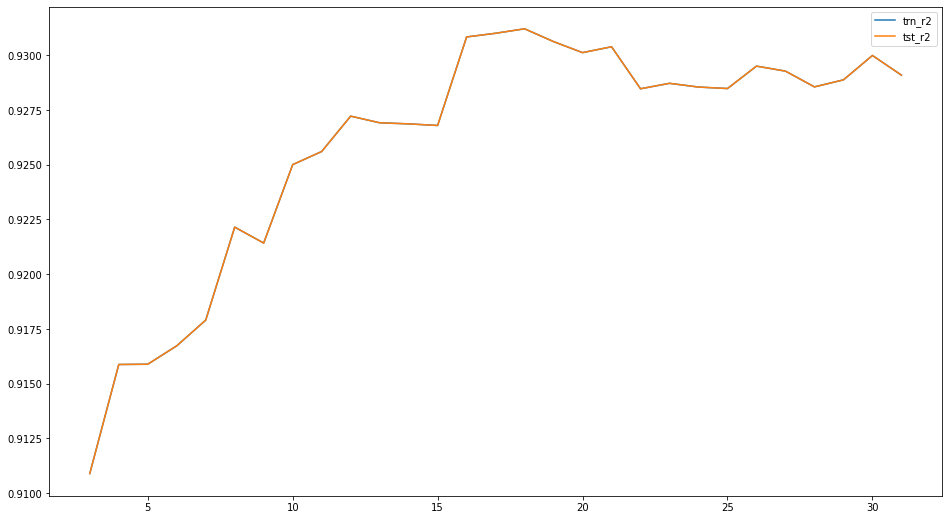

time: 164 ms (started: 2022-02-27 01:59:27 +03:00)


In [38]:
ax = mlp_otbor_r2.applymap(np.mean).plot(figsize=(16,9))
# ax.get_figure().savefig('mlp_otbor_r2_1h_committee.png')

In [39]:
emsembles_path

'/home/roman/Projects/Cosmos/GPU_features_selection_exps/feature_selection_trn2016_GB_del_2h/ensembles'

time: 2.3 ms (started: 2022-02-27 01:59:27 +03:00)


In [33]:
model = joblib.load(f'{emsembles_path}/mlp_model_18')


f = ['doySin', 'hourSin', 'doyCos', 'hourCos'] + best_set_sorted[:18]


print(model.score(X_tst_std[f], y_tst_std))
print(best_set_sorted[:18])


0.8899255518406106
['Dst_-0', 'B_gsm_z_-0', 'SW_spd_-0', 'B_gsm_z_-3', 'B_gsm_z_-1', 'Dst_-21', 'H_den_SWP_-0', 'H_den_SWP_-2', 'Dst_-7', 'B_magn_-4', 'B_gsm_z_-2', 'H_den_SWP_-1', 'Dst_-5', 'Dst_-3', 'SW_spd_-1', 'B_magn_-0', 'Dst_-10', 'B_gsm_y_-8']
time: 529 ms (started: 2022-02-27 15:12:32 +03:00)


In [41]:
tst_rmse = [sum(e)/len(e) for e in tst_rmse]

time: 940 µs (started: 2022-02-27 01:59:28 +03:00)


In [42]:
# минимум кривой rmse
tst_rmse.index(min(tst_rmse))+3, round(min(tst_rmse), 4)

(18, 5.3192)

time: 4.62 ms (started: 2022-02-27 01:59:28 +03:00)


In [43]:
tst_r2 = [sum(e)/len(e) for e in tst_r2]

time: 1.05 ms (started: 2022-02-27 01:59:28 +03:00)


In [44]:
# максимум кривой r2
tst_r2.index(max(tst_r2))+3, round(max(tst_r2), 4)

(18, 0.9312)

time: 4.54 ms (started: 2022-02-27 01:59:28 +03:00)


In [45]:
len(f), f

(22,
 ['doySin',
  'hourSin',
  'doyCos',
  'hourCos',
  'Dst_-0',
  'B_gsm_z_-0',
  'SW_spd_-0',
  'B_gsm_z_-3',
  'B_gsm_z_-1',
  'Dst_-21',
  'H_den_SWP_-0',
  'H_den_SWP_-2',
  'Dst_-7',
  'B_magn_-4',
  'B_gsm_z_-2',
  'H_den_SWP_-1',
  'Dst_-5',
  'Dst_-3',
  'SW_spd_-1',
  'B_magn_-0',
  'Dst_-10',
  'B_gsm_y_-8'])

time: 4.87 ms (started: 2022-02-27 01:59:28 +03:00)


Учим комитет mlp на полном наборе 
===

In [34]:
if os.path.isfile(f'{emsembles_path}/regressor_full_committee.joblib'):
    regressor_full = joblib.load(f'{emsembles_path}/regressor_full_committee.joblib')
    print(1)
else:
    print(0)

1
time: 160 ms (started: 2022-02-27 15:12:32 +03:00)


In [35]:
if os.path.isfile(f'{emsembles_path}/regressor_full_committee.joblib'):
    regressor_full = joblib.load(f'{emsembles_path}/regressor_full_committee.joblib')
else:    
    regressor_full = VotingRegressor([("0", MLPRegressor(hidden_layer_sizes=(32,),
                                                  solver='sgd',
                                                  learning_rate_init=0.001,
                                                  alpha=0.01,
                                                  validation_fraction=0.2,
                                                  max_iter=3000,
                                                  n_iter_no_change=500,
                        #                               verbose=True, 
                                                  early_stopping=True,
                                                  activation='tanh')),
                                     ("1", MLPRegressor(hidden_layer_sizes=(32,),
                                                  solver='sgd',
                                                  learning_rate_init=0.001,
                                                  alpha=0.01,
                                                  validation_fraction=0.2,
                                                  max_iter=3000,
                                                  n_iter_no_change=500,
                        #                               verbose=True, 
                                                  early_stopping=True,
                                                  activation='tanh')),
                                     ("2", MLPRegressor(hidden_layer_sizes=(32,),
                                                  solver='sgd',
                                                  learning_rate_init=0.001,
                                                  alpha=0.01,
                                                  validation_fraction=0.2,
                                                  max_iter=3000,
                                                  n_iter_no_change=500,
                        #                               verbose=True, 
                                                  early_stopping=True,
                                                  activation='tanh')),
                                     ("3", MLPRegressor(hidden_layer_sizes=(32,),
                                                  solver='sgd',
                                                  learning_rate_init=0.001,
                                                  alpha=0.01,
                                                  validation_fraction=0.2,
                                                  max_iter=3000,
                                                  n_iter_no_change=500,
                        #                               verbose=True, 
                                                  early_stopping=True,
                                                  activation='tanh')),
                                     ("4", MLPRegressor(hidden_layer_sizes=(32,),
                                                  solver='sgd',
                                                  learning_rate_init=0.001,
                                                  alpha=0.01,
                                                  validation_fraction=0.2,
                                                  max_iter=3000,
                                                  n_iter_no_change=500,
                        #                               verbose=True, 
                                                  early_stopping=True,
                                                  activation='tanh'))])

    X_trn_std, y_trn_std, X_tst_std, y_tst_std, in_, out_= trn_tst_scal(data_transformed, X.columns, [f'Dst_+{fc_hours}'], trn_cond, in_scaler, out_scaler)
    regressor_full.fit(X_trn_std, y_trn_std)
    joblib.dump(regressor_full, f'{emsembles_path}/regressor_full_committee.joblib')

time: 82.7 ms (started: 2022-02-27 15:12:32 +03:00)


In [36]:
linreg_full = LinearRegression()
linreg_best = LinearRegression()

X_trn_std, y_trn_std, X_tst_std, y_tst_std, in_, out_= trn_tst_scal(data_transformed, X.columns, [fc_colname], trn_cond, in_scaler, out_scaler)

linreg_full.fit(X_trn_std, y_trn_std)
linreg_best.fit(X_trn_std[best_set], y_trn_std)

LinearRegression()

time: 3.61 s (started: 2022-02-27 15:12:33 +03:00)


Тривиальная модель (важен переданный набор данных (из-за кол-ва сэмплов) важен горизонт (на столько короче из-за сдвига  станет итоговый array
===

In [37]:
def tr_model_1(df, horizont):
    res = df['Dst_-0'].shift(horizont)
    return res

y_pred_triv = out_scaler.inverse_transform(tr_model_1(X_tst_std, fc_hours).dropna().to_frame())

time: 5.87 ms (started: 2022-02-27 15:12:36 +03:00)


In [38]:
y_pred_triv

array([[-13.],
       [-14.],
       [-16.],
       ...,
       [-26.],
       [-23.],
       [-19.]])

time: 5.05 ms (started: 2022-02-27 15:12:36 +03:00)


In [39]:
linreg_full

LinearRegression()

time: 6.29 ms (started: 2022-02-27 15:12:36 +03:00)


In [40]:
features = f

time: 723 µs (started: 2022-02-27 15:12:36 +03:00)


In [41]:
y_true = out_scaler.inverse_transform(y_tst_std).reshape(len(y_tst_std))
y_mlp_full = out_scaler.inverse_transform(regressor_full.predict(X_tst_std)[:, None]).reshape(len(y_tst_std))
y_mlp_best = out_scaler.inverse_transform(model.predict(X_tst_std[features])[:, None]).reshape(len(y_tst_std))

y_xgb_full = out_scaler.inverse_transform(xgb_full.predict(X_tst_std)[:, None]).reshape(len(y_tst_std))
y_xgb_best = out_scaler.inverse_transform(xgb_best.predict(X_tst_std[best_set])[:, None]).reshape(len(y_tst_std))

y_linreg_full = out_scaler.inverse_transform(linreg_full.predict(X_tst_std)).reshape(len(y_tst_std))
y_linreg_best = out_scaler.inverse_transform(linreg_best.predict(X_tst_std[best_set])).reshape(len(y_tst_std))

y_pred_triv = out_scaler.inverse_transform(tr_model_1(X_tst_std, fc_hours).dropna().to_frame())

df_tst = pd.DataFrame({'Прогнозируемое значение':y_true,
                       'XGB на полном наборе':y_xgb_full,
                       'XGB на лучшем наборе':y_xgb_best,
                       'МСП полном наборе ':y_mlp_full,
                       'МСП на лучшем наборе ':y_mlp_best,
                       'Лин регрессия на полном наборе':y_linreg_full,
                       'Лин регрессия на лучшем наборе':y_linreg_best})
df_tst.index = X_tst_std.index
df_tst = df_tst[:-fc_hours]
df_tst['Тривиальная модель'] = y_pred_triv
df_tst.to_csv(f'stats_tst_{fc_hours}h.csv')
df_tst

,Прогнозируемое значение,XGB на полном наборе,XGB на лучшем наборе,МСП полном наборе,МСП на лучшем наборе,Лин регрессия на полном наборе,Лин регрессия на лучшем наборе,Тривиальная модель
timestamp,,,,,,,,
2017-01-01 00:00:00,-16.0,-17.431723,-17.195768,-18.532939,-18.160708,-17.367587,-18.349275,-13.0
2017-01-01 01:00:00,-24.0,-18.075275,-18.385174,-18.755722,-18.357195,-16.709338,-17.398510,-14.0
2017-01-01 02:00:00,-30.0,-22.153381,-23.716503,-21.907347,-20.998068,-20.446096,-20.957087,-16.0
2017-01-01 03:00:00,-31.0,-29.212790,-30.268332,-25.577016,-27.139014,-28.160951,-28.065720,-24.0
2017-01-01 04:00:00,-29.0,-32.298927,-32.618099,-29.884185,-30.442944,-30.654965,-30.912798,-30.0
...,...,...,...,...,...,...,...,...
2022-01-09 11:00:00,-26.0,-17.842789,-18.004061,-15.750279,-17.298012,-15.035478,-16.000715,-21.0
2022-01-09 12:00:00,-23.0,-22.226753,-22.551504,-18.949226,-21.335603,-21.172475,-21.224171,-25.0
2022-01-09 13:00:00,-19.0,-22.070919,-22.395130,-19.888352,-21.101516,-20.716468,-20.283543,-26.0


time: 2.17 s (started: 2022-02-27 15:12:36 +03:00)


In [42]:
y_true = out_scaler.inverse_transform(y_trn_std).reshape(len(y_trn_std))

y_mlp_full = out_scaler.inverse_transform(regressor_full.predict(X_trn_std)[:, None]).reshape(len(y_trn_std))
y_mlp_best = out_scaler.inverse_transform(model.predict(X_trn_std[features])[:, None]).reshape(len(y_trn_std))

y_xgb_full = out_scaler.inverse_transform(xgb_full.predict(X_trn_std)[:, None]).reshape(len(y_trn_std))
y_xgb_best = out_scaler.inverse_transform(xgb_best.predict(X_trn_std[best_set])[:, None]).reshape(len(y_trn_std))

y_linreg_full = out_scaler.inverse_transform(linreg_full.predict(X_trn_std)).reshape(len(y_trn_std))
y_linreg_best = out_scaler.inverse_transform(linreg_best.predict(X_trn_std[best_set])).reshape(len(y_trn_std))

y_pred_triv = out_scaler.inverse_transform(tr_model_1(X_trn_std, fc_hours).dropna().to_frame())

df_trn = pd.DataFrame({'Прогнозируемое значение':y_true,
                       'XGB на полном наборе':y_xgb_full,
                       'XGB на лучшем наборе':y_xgb_best,
                       'МСП полном наборе ':y_mlp_full,
                       'МСП на лучшем наборе ':y_mlp_best,
                       'Лин регрессия на полном наборе':y_linreg_full,
                       'Лин регрессия на лучшем наборе':y_linreg_best})
df_trn.index = X_trn_std.index
df_trn = df_trn[:-fc_hours]
df_trn['Тривиальная модель'] = y_pred_triv
df_trn.to_csv(f'stats_trn_{fc_hours}h.csv')
df_trn

,Прогнозируемое значение,XGB на полном наборе,XGB на лучшем наборе,МСП полном наборе,МСП на лучшем наборе,Лин регрессия на полном наборе,Лин регрессия на лучшем наборе,Тривиальная модель
timestamp,,,,,,,,
1997-10-21 23:00:00,2.0,5.048874,5.218021,7.019325,7.110214,7.472847,7.532379,3.0
1997-10-22 00:00:00,-4.0,-0.327416,0.155064,-3.750217,-4.228643,-7.068757,-6.638396,2.0
1997-10-22 01:00:00,-7.0,-7.977327,-7.208416,-8.668381,-9.707480,-9.831022,-9.495052,2.0
1997-10-22 02:00:00,-3.0,-8.636997,-7.663008,-11.299638,-12.177936,-11.645845,-11.758526,-4.0
1997-10-22 03:00:00,-1.0,-1.799076,-1.914835,-3.976255,-5.124754,-2.084693,-2.828932,-7.0
...,...,...,...,...,...,...,...,...
2016-12-31 17:00:00,-19.0,-15.952205,-13.672744,-23.192456,-21.372964,-22.472503,-22.530141,-16.0
2016-12-31 18:00:00,-25.0,-18.913013,-17.755287,-25.662403,-21.524883,-23.768103,-22.589144,-16.0
2016-12-31 19:00:00,-24.0,-21.113417,-21.345596,-24.380549,-20.932181,-23.026304,-22.520254,-19.0


time: 6.72 s (started: 2022-02-27 15:12:38 +03:00)


In [43]:
for col in df_trn.columns[1:]:
    print(col, 'R2_trn = ', round(r2_score(df_trn['Прогнозируемое значение'], df_trn[col]), 4))
    print(col, 'R2_tst = ', round(r2_score(df_tst['Прогнозируемое значение'], df_tst[col]), 4))
    print(col, 'RMSE_trn = ', round(np.sqrt(mean_squared_error(df_trn['Прогнозируемое значение'], df_trn[col])), 4))
    print(col, 'RMSE_tst = ', round(np.sqrt(mean_squared_error(df_tst['Прогнозируемое значение'], df_tst[col])), 4), '\n')

XGB на полном наборе R2_trn =  0.963
XGB на полном наборе R2_tst =  0.9076
XGB на полном наборе RMSE_trn =  3.8988
XGB на полном наборе RMSE_tst =  3.8103 

XGB на лучшем наборе R2_trn =  0.9602
XGB на лучшем наборе R2_tst =  0.9059
XGB на лучшем наборе RMSE_trn =  4.048
XGB на лучшем наборе RMSE_tst =  3.8445 

МСП полном наборе  R2_trn =  0.9312
МСП полном наборе  R2_tst =  0.8848
МСП полном наборе  RMSE_trn =  5.3199
МСП полном наборе  RMSE_tst =  4.2538 

МСП на лучшем наборе  R2_trn =  0.9324
МСП на лучшем наборе  R2_tst =  0.8899
МСП на лучшем наборе  RMSE_trn =  5.2724
МСП на лучшем наборе  RMSE_tst =  4.1578 

Лин регрессия на полном наборе R2_trn =  0.9336
Лин регрессия на полном наборе R2_tst =  0.8911
Лин регрессия на полном наборе RMSE_trn =  5.2263
Лин регрессия на полном наборе RMSE_tst =  4.1358 

Лин регрессия на лучшем наборе R2_trn =  0.932
Лин регрессия на лучшем наборе R2_tst =  0.8902
Лин регрессия на лучшем наборе RMSE_trn =  5.2863
Лин регрессия на лучшем наборе 

In [55]:
', '.join(colonki_2.applymap(np.mean).isnull().sum(axis=1).sort_values().index.tolist())

'Dst_-0, B_gsm_z_-0, SW_spd_-0, B_gsm_z_-3, B_gsm_z_-1, Dst_-21, H_den_SWP_-0, H_den_SWP_-2, Dst_-7, B_magn_-4, B_gsm_z_-2, H_den_SWP_-1, Dst_-5, Dst_-3, SW_spd_-1, B_magn_-0, Dst_-10, B_gsm_y_-8, SW_spd_-2, Dst_-19, Dst_-20, Dst_-1, B_magn_-15, B_gsm_y_-6, Dst_-22, SW_spd_-4, B_magn_-11, B_magn_-3, SW_spd_-16, Dst_-23, B_gsm_y_-22, Dst_-11, B_magn_-12, Dst_-9, SW_spd_-21, B_gsm_z_-8, Dst_-17, B_magn_-6, B_gsm_y_-7, B_magn_-22, SW_spd_-7, B_gsm_y_-1, H_den_SWP_-3, B_gsm_y_-0, H_den_SWP_-6, B_gsm_z_-10, B_gsm_y_-23, Dst_-2, H_den_SWP_-16, Dst_-16, B_magn_-23, B_magn_-7, B_magn_-18, SW_spd_-3, H_den_SWP_-11, B_gsm_z_-7, H_den_SWP_-20, Dst_-15, B_gsm_z_-4, Dst_-13, B_magn_-5, Dst_-4, H_den_SWP_-7, B_gsm_z_-22, H_den_SWP_-19, Dst_-18, B_gsm_z_-21, B_gsm_z_-5, H_den_SWP_-4, SW_spd_-5, B_gsm_z_-16, B_gsm_y_-2, H_den_SWP_-5, SW_spd_-18, B_gsm_y_-5, H_den_SWP_-8, B_gsm_z_-19, SW_spd_-12, B_magn_-16, B_gsm_z_-11, H_den_SWP_-10, B_magn_-9, B_gsm_z_-18, B_gsm_y_-9, SW_spd_-23, SW_spd_-14, B_gsm_y

time: 169 ms (started: 2022-02-07 11:58:10 +03:00)
